## Deep QNetworks

Deep Qlearning with experience replay.

In [10]:
import sys
sys.path.append('../src_code')

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from qnetworks import ReplayBuffer
from deep_qnetworks import DQN, SnakeEnv
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64  # Size of batch taken from replay buffer

In [4]:
# initialize the environment 
Lx = 20
Ly = 20

env = SnakeEnv(Lx,Ly)

# The first model makes the predictions for Q-values which are used to make a action.
model = DQN(in_channels =1, num_actions=env.num_actions, input_size=env.Lx)
# The target model makes the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = DQN(in_channels = 1, num_actions=env.num_actions, input_size=env.Lx)

model.to(device)
model_target.to(device)

# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)
# huber loss
loss_function = nn.HuberLoss()

num_actions = env.num_actions
action_space = np.arange(num_actions)

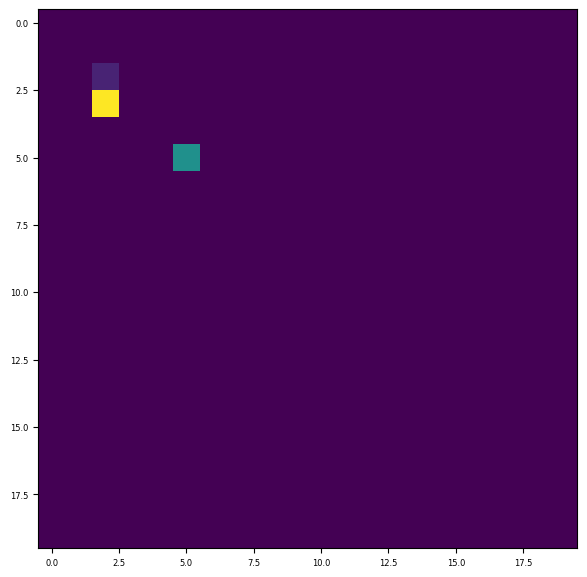

In [5]:
# brief check to see the snake moves as expected

env.reset()
S_new, reward, done = env.single_step([0,0,2,2], 2)
#plt.imshow(env.get_image(S_new))

S_new, reward, done = env.single_step(S_new, 2)
S_new, reward, done = env.single_step(S_new, 0)
S_new, reward, done = env.single_step(S_new, 0)

S_new, reward, done = env.single_step([S_new[0],S_new[1],5,5, S_new[4]], 0)
plt.imshow(env.get_image(S_new))


In [8]:
def train_step(states, actions, rewards, next_states, dones, discount):
    """
    Perform a training iteration on a batch of data sampled from the experience
    replay buffer.

    Takes as input:
        - states: a batch of states
        - actions: a batch of actions
        - rewards: a batch of rewards
        - next_states: a batch of next states
        - dones: a batch of dones
        - discount: the discount factor, standard discount factor in RL to evaluate less long term rewards
    """

    # compute targets for Q-learning
    # the max Q-value of the next state is the target for the current state
    # the image to be fed to the network is a grey scale image of the world
    images = [env.get_image(next_state) for next_state in next_states]
    input = torch.as_tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)
    max_next_qs = model_target(input).max(-1).values

    # transform into tensors and move to device
    rewards = torch.as_tensor(rewards, dtype=torch.float32).to(device)
    dones = torch.as_tensor(dones, dtype=torch.float32).to(device)


    # if the next state is terminal, then the Q-value is just the reward
    # otherwise, we add the discounted max Q-value of the next state
    target = rewards + (1.0 - dones) * discount * max_next_qs

    # then to compute the loss, we also need the Q-value of the current state
    images = [env.get_image(state) for state in states]
    input = torch.as_tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)
    qs = model(input)

    # for each state, we update ONLY the Q-value of the action that was taken
    action_masks = F.one_hot(torch.as_tensor(np.array(actions)).long(), num_actions)
    masked_qs = (action_masks * qs).sum(dim=-1)
    loss = loss_function(masked_qs, target.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# initialize the buffer, with a size of 100000, when it is full, it will remove the oldest element
buffer = ReplayBuffer(size = 100000, device=device) 

cur_frame = 0
last_100_ep_rewards = []
last_100_ep_steps = []
food_eaten = []

max_steps_per_episode = 500
max_num_episodes = 10000

epsilon = 1
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter

# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 10000

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0

filename = 'dqn_results.txt'
env.start = np.array([0,0])

# write config to file
with open(filename, 'w') as f:
    f.write('Lx: ' + str(Lx) + '\n')
    f.write('max_steps_per_episode: ' + str(max_steps_per_episode) + '\n')
    f.write('max_num_episodes: ' + str(max_num_episodes) + '\n')
    f.write('epsilon_min: ' + str(epsilon_min) + '\n')
    f.write('epsilon_max: ' + str(epsilon_max) + '\n')
    f.write('update_after_actions: ' + str(update_after_actions) + '\n')
    f.write('update_target_network: ' + str(update_target_network) + '\n')
    f.write('epsilon_random_frames: ' + str(epsilon_random_frames) + '\n')
    f.write('epsilon_greedy_frames: ' + str(epsilon_greedy_frames) + '\n')
    f.write('episode,running_reward,epsilon,mean_steps,mean_food\n')

for episode in tqdm(range(max_num_episodes)):
    env.reset()
    episode_reward = 0

    # state is a tuple of 4 values made of starting position and goal position
    # start of an episode is always [0,0] for snake and a random position for goal
    start_x = env.start[0]
    start_y = env.start[1]
    goal_x = np.random.randint(0,env.Lx)
    goal_y = np.random.randint(0,env.Ly)

    body = []
    state = [start_x, start_y, goal_x, goal_y, []]


    timestep = 0
    food = 0
    done = False
    
    
    while timestep < max_steps_per_episode and not done:
    
        cur_frame += 1
        action = env.select_epsilon_greedy_action(model, state, epsilon)
        
        next_state, reward, done = env.single_step(state, action)
        episode_reward += reward
    

        # Save actions and states in replay buffer
        buffer.add(state, action, reward, next_state, done)
        state = next_state
        cur_frame += 1
    
        # Train neural network
        if len(buffer) > batch_size and cur_frame % update_after_actions == 0:
            states, actions, rewards, next_states, dones = buffer.sample(batch_size)
            loss = train_step(states, actions, rewards, next_states, dones, discount=0.99)
        
        # Update target network every update_target_network steps
        if cur_frame % update_target_network == 0:
            model_target.load_state_dict(model.state_dict())

        timestep += 1

        """ epsilon -= (epsilon_max - epsilon_min) / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min) """



    if len(last_100_ep_rewards) == 100:
        last_100_ep_rewards = last_100_ep_rewards[1:]
        last_100_ep_steps = last_100_ep_steps[1:]
        food_eaten = food_eaten[1:]

    last_100_ep_rewards.append(episode_reward)
    last_100_ep_steps.append(timestep)
    food_eaten.append(food)

    running_reward = np.mean(last_100_ep_rewards)
    mean_steps = np.mean(last_100_ep_steps)
    mean_food = np.mean(food_eaten)

    if episode % 100 == 0:
        # write on file current average reward
        with open(filename, 'a') as f:
            f.write(f'{episode},{running_reward:.2f}, {epsilon:.3f}, {mean_steps:.3f}, {mean_food}\n')

        epsilon -= 0.025
        epsilon = max(epsilon, epsilon_min)
    
        
    # Condition to consider the task solved
    # e.g. to eat at least 6 consecutive food items
    # without eating itself, considering also the moves to reach the food
    if running_reward > 500: 
        print("Solved at episode {}!".format(episode))
        break